<a href="https://colab.research.google.com/github/hrifanov/ml_project/blob/main/contrastive_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut, KFold
import keras
import pandas as pd
import numpy as np
import cv2
import os
import random

In [ ]:
images_path = "drive/MyDrive/Dataset/img_celeba_cropped/"
celeb = "drive/MyDrive/Dataset/colab_df.txt"

In [ ]:
oimage_shape=(224, 224, 3)

batch_size=16
lr=0.00001

In [ ]:
balanced_df = pd.read_csv(celeb)
balanced_df["left"] = balanced_df["left"].str.replace("../../Dataset/img_celeba_cropped/", "drive/MyDrive/Dataset/img_celeba_cropped/")
balanced_df["right"] = balanced_df["right"].str.replace("../../Dataset/img_celeba_cropped/", "drive/MyDrive/Dataset/img_celeba_cropped/")
balanced_df

<ipython-input-4-3f1dab5bc255>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  balanced_df["left"] = balanced_df["left"].str.replace("../../Dataset/img_celeba_cropped/", "drive/MyDrive/Dataset/img_celeba_cropped/")
<ipython-input-4-3f1dab5bc255>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  balanced_df["right"] = balanced_df["right"].str.replace("../../Dataset/img_celeba_cropped/", "drive/MyDrive/Dataset/img_celeba_cropped/")


,left,right,label
0,drive/MyDrive/Dataset/img_celeba_cropped/07543...,drive/MyDrive/Dataset/img_celeba_cropped/10458...,1
1,drive/MyDrive/Dataset/img_celeba_cropped/10458...,drive/MyDrive/Dataset/img_celeba_cropped/10491...,0
2,drive/MyDrive/Dataset/img_celeba_cropped/19053...,drive/MyDrive/Dataset/img_celeba_cropped/19531...,1
3,drive/MyDrive/Dataset/img_celeba_cropped/19531...,drive/MyDrive/Dataset/img_celeba_cropped/08501...,0
4,drive/MyDrive/Dataset/img_celeba_cropped/12847...,drive/MyDrive/Dataset/img_celeba_cropped/00324...,1
...,...,...,...
3515,drive/MyDrive/Dataset/img_celeba_cropped/00758...,drive/MyDrive/Dataset/img_celeba_cropped/04726...,0
3516,drive/MyDrive/Dataset/img_celeba_cropped/09948...,drive/MyDrive/Dataset/img_celeba_cropped/12712...,1
3517,drive/MyDrive/Dataset/img_celeba_cropped/12712...,drive/MyDrive/Dataset/img_celeba_cropped/08628...,0
3518,drive/MyDrive/Dataset/img_celeba_cropped/19312...,drive/MyDrive/Dataset/img_celeba_cropped/19159...,1


In [ ]:
train_df, test_df, validate_df = np.split(balanced_df, [int(.8*len(balanced_df)), int(.9*len(balanced_df))])

In [ ]:
X_train = train_df[["left", "right"]]
Y_train_label = train_df[["label"]]

X_test = test_df[["left", "right"]]
Y_test_label = test_df[["label"]]

X_val = validate_df[["left", "right"]]
Y_val_label = validate_df[["label"]]

In [ ]:
print('=====Training=====')
print(X_train.shape)
print(Y_train_label.shape)

print('=====Testing=====')
print(X_test.shape)
print(Y_test_label.shape)

print('=====Validate=====')
print(X_val.shape)
print(Y_val_label.shape)

=====Training=====
(2816, 2)
(2816, 1)
=====Testing=====
(352, 2)
(352, 1)
=====Validate=====
(352, 2)
(352, 1)


In [ ]:
def preprocessing(left, right):
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [ ]:
def create_dataset(features, labels):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    #data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
    #                                      layers.RandomRotation(0.1),
    #                                      layers.RandomZoom(0.1)])
    
    feature_ds = feature_ds.map(preprocessing)
    labels_ds = labels_ds.map(label_preprocessing)
    
    #normalization_layer = tf.keras.layers.Rescaling(1./255)
    #feature_ds = feature_ds.map(lambda image_left, image_right: (normalization_layer(image_left), normalization_layer(image_right)))
    
    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [ ]:
train_ds = create_dataset(X_train, Y_train_label)
test_ds = create_dataset(X_test, Y_test_label)
val_ds = create_dataset(X_val, Y_val_label)
train_ds

<PrefetchDataset element_spec=((TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
left_input = layers.Input(shape=image_shape, name='left_input')
right_input = layers.Input(shape=image_shape, name='right_input')

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
def tower_network():
  input = layers.Input((image_shape))
  scaled_input = layers.Rescaling(1/255, 0.0)(input)

  x = layers.Conv2D(32, (10, 10), activation="relu", padding="same")(scaled_input)
  x = layers.MaxPool2D((2, 2))(x)

  x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
  x = layers.MaxPool2D((2, 2))(x)

  x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
  x = layers.MaxPool2D((2, 2))(x)

  x = layers.GlobalAveragePooling2D()(x)

  x = layers.Flatten()(x)
  output = layers.Dense(64, activation="relu")(x)
  
  return Model(inputs=input, outputs=output, name="tower_network")

In [ ]:
def siamese_lambda_network():
    embedding_network = tower_network()
    # initializing the left "tower"
    left_tower_input = layers.Input(shape=(224,224,3), name = "left_tower")
    left_tower = embedding_network(left_tower_input)
    # initializing the right "tower"
    right_tower_input = layers.Input(shape=(224,224,3), name = "right_tower")
    right_tower = embedding_network(right_tower_input)
    # merge, normalize, and output
    merge_layer = layers.Lambda(euclidean_distance, name = "lambda_layer")([left_tower, right_tower])
    
    dense_1 = layers.Dense(64, activation = "relu")(merge_layer)
    
    output_layer = layers.Dense(1, activation="sigmoid")(dense_1)
    
    return Model([left_tower_input, right_tower_input], output_layer, name = "siamese_lambda_network")

In [ ]:
model = siamese_lambda_network()

In [ ]:
def cont_loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
model.compile(loss=cont_loss(0.2), optimizer=Adam(learning_rate=lr))
model.summary()

Model: "siamese_lambda_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_tower (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_tower (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tower_network (Functional)     (None, 64)           143008      ['left_tower[0][0]',             
                                                                  'right_towe

In [ ]:
callback_list = []

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
callback_list.append(early_stopping)

In [ ]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callback_list)

Epoch 1/20
176/176 [==============================] - 30s 138ms/step - loss: 0.1247 - val_loss: 0.1244
Epoch 2/20
176/176 [==============================] - 14s 82ms/step - loss: 0.1241 - val_loss: 0.1238
Epoch 3/20
176/176 [==============================] - 15s 83ms/step - loss: 0.1235 - val_loss: 0.1231
Epoch 4/20
176/176 [==============================] - 15s 83ms/step - loss: 0.1227 - val_loss: 0.1223
Epoch 5/20
176/176 [==============================] - 15s 84ms/step - loss: 0.1219 - val_loss: 0.1214
Epoch 6/20
176/176 [==============================] - 15s 84ms/step - loss: 0.1209 - val_loss: 0.1203
Epoch 7/20
176/176 [==============================] - 15s 84ms/step - loss: 0.1198 - val_loss: 0.1191
Epoch 8/20
176/176 [==============================] - 15s 86ms/step - loss: 0.1185 - val_loss: 0.1176
Epoch 9/20
176/176 [==============================] - 15s 84ms/step - loss: 0.1164 - val_loss: 0.1146
Epoch 10/20
176/176 [==============================] - 15s 84ms/step - loss: 0.11

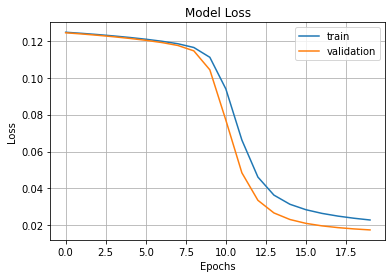

In [ ]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

In [ ]:
def create_dataset_no_labels(features):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    feature_ds = feature_ds.map(preprocessing)
    
    feature_ds = feature_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    feature_ds = feature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return feature_ds

def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [ ]:
test_ds_left = create_singular_dataset(X_test['left'])
test_ds_right = create_singular_dataset(X_test['right'])
test_labels = Y_test_label['label']

test_ds_full = create_dataset_no_labels(X_test)

In [ ]:
predictions = model.predict(val_ds)

22/22 [==============================] - 1s 32ms/step


In [ ]:
predictions_for_accuracy = predictions.flatten()
predictions_for_accuracy = predictions_for_accuracy.tolist()

In [ ]:
predictions_labels = pd.DataFrame({"labels":test_labels, 
                                   "predictions":predictions_for_accuracy})
predictions_labels

,labels,predictions
2816,1,0.000158
2817,0,0.077313
2818,1,0.002482
2819,0,0.331783
2820,1,0.016520
...,...,...
3163,0,0.298571
3164,1,0.339218
3165,0,0.005898
3166,1,0.029496


In [ ]:
predictions_labels_positive = predictions_labels["predictions"].loc[predictions_labels["labels"] == 1]
predictions_labels_negative = predictions_labels["predictions"].loc[predictions_labels["labels"] == 0]
positive_mean = predictions_labels_positive.mean()
negative_mean = predictions_labels_negative.mean()
predictions_labels_positive

2816    0.000158
2818    0.002482
2820    0.016520
2822    0.093826
2824    0.001016
          ...   
3158    0.029770
3160    0.003032
3162    0.003123
3164    0.339218
3166    0.029496
Name: predictions, Length: 176, dtype: float64

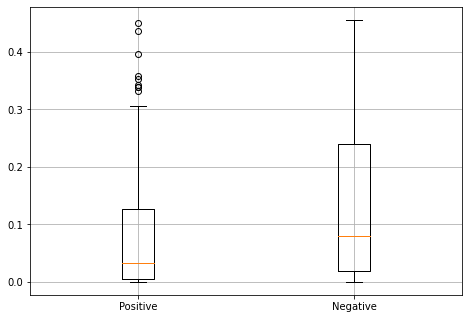

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([predictions_labels_negative, predictions_labels_positive])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [ ]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred > cutoff
    return np.mean(pred == y_true), pred

In [ ]:
cutoff = (positive_mean + negative_mean)/2

test_accuracy, y_pred = compute_accuracy(test_labels, predictions_for_accuracy, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 57.67%


In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([cv2.cvtColor(cv2.imread(pairs["left"].iloc[i]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(pairs["right"].iloc[i]), cv2.COLOR_BGR2RGB)], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels["label"].iloc[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

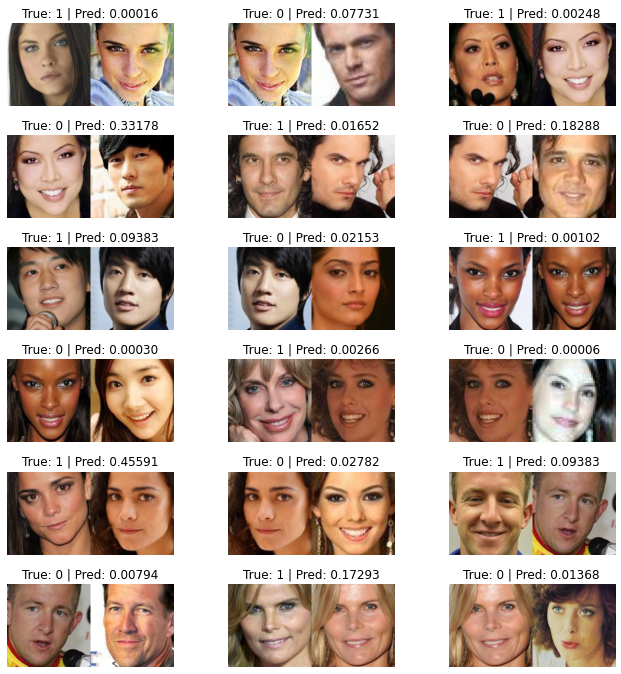

In [ ]:
visualize(X_val, Y_val_label, to_show=18, num_col=3, predictions=predictions, test=True)